In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import json
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
DELETE_THRESHOLD = 40 # 缺失删除比例阈值（百分比）
CRAMERS_V_THRESHOLD = 0.6 # cramer's v冗余特征相关性阈值
PEARSON_THRESHOLD = 0.8 # 皮尔逊相关性冗余特征相关性阈值
N_BINS_WIDTH = 5 # 等宽分箱数
N_BINS_FREQ = 5 # 等频分箱数

In [3]:
df = pd.read_csv('data/train.csv') # 读取数据
df[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 1. 缺失值检测与处理

1.1. 缺失值检测

In [4]:
# 计算每个特征的缺失值数量和比例
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
# 创建缺失值统计表
missing_df = pd.DataFrame({
    '特征名称': missing_data.index,
    '缺失数量': missing_data.values,
    '缺失比例(%)': missing_percent.values
})
# 有缺失值的特征
missing_df = missing_df[missing_df['缺失数量'] > 0].sort_values('缺失数量', ascending=False)

print("缺失值统计：")
print(missing_df)
print(f"有缺失值的特征数/总特征数: {len(missing_df)}/{len(df.columns)}")

缺失值统计：
            特征名称  缺失数量    缺失比例(%)
72        PoolQC  1453  99.520548
74   MiscFeature  1406  96.301370
6          Alley  1369  93.767123
73         Fence  1179  80.753425
25    MasVnrType   872  59.726027
57   FireplaceQu   690  47.260274
3    LotFrontage   259  17.739726
58    GarageType    81   5.547945
59   GarageYrBlt    81   5.547945
60  GarageFinish    81   5.547945
63    GarageQual    81   5.547945
64    GarageCond    81   5.547945
35  BsmtFinType2    38   2.602740
32  BsmtExposure    38   2.602740
33  BsmtFinType1    37   2.534247
31      BsmtCond    37   2.534247
30      BsmtQual    37   2.534247
26    MasVnrArea     8   0.547945
42    Electrical     1   0.068493
有缺失值的特征数/总特征数: 19/81


1.2. 缺失值处理
- 删除严重缺失值：如果某列缺失比例很高（超过40%），可以考虑直接删除该列。
- 填充剩余缺失值：使用KNN模型预测数值型特征缺失值；使用众数填充分类型特征缺失值。

In [5]:
# 删除缺失比例超过40%的列
# DELETE_THRESHOLD  # 缺失比例阈值（百分比）

high_na_cols = missing_df[missing_df['缺失比例(%)'] > DELETE_THRESHOLD]['特征名称'].tolist()
df = df.drop(columns=high_na_cols)
print(f"已删除缺失比例超过{DELETE_THRESHOLD}%的{len(high_na_cols)}列: {high_na_cols}")

# 对数值型特征的缺失值用KNN进行填充
print("KNN填充前缺失值数量：", df.isnull().sum().sum())
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])
print("KNN填充后剩余缺失值数量：", df.isnull().sum().sum())

# 无法进行KNN填充的分类型特征用众数填充
remain_na_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
for col in remain_na_cols:
    mode = df[col].mode() # 获取众数
    if not mode.empty:
        df[col] = df[col].fillna(mode[0]) # 用众数填充缺失值
print("众数填充后总缺失值数量：", df.isnull().sum().sum())

已删除缺失比例超过40%的6列: ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']
KNN填充前缺失值数量： 860
KNN填充后剩余缺失值数量： 512
众数填充后总缺失值数量： 0


# 2. 异常值检测与处理

2.1. 基于分类型特征范围的异常数据检测与处理
- 根据feature_values.json中定义的特征值有效范围，检测数据集中超出范围的异常值

In [6]:
# 加载特征值json文件
with open('data/feature_values.json', 'r', encoding='utf-8') as f:
    feature_values = json.load(f)
# 自动推断分类型特征（object类型或category类型）
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# 验证值是否在定义范围内
invalid_values = {} # 存储无效值
for feature in categorical_features:
    if feature in feature_values:
        valid_values = set(feature_values[feature])
        actual_values = set(df[feature].unique())
        invalid_vals = actual_values - valid_values
        if invalid_vals:
            invalid_values[feature] = list(invalid_vals)
            print(f"{feature}: 发现无效值 {list(invalid_vals)}")

MSZoning: 发现无效值 ['C (all)']
Neighborhood: 发现无效值 ['NAmes']
BldgType: 发现无效值 ['Duplex', 'Twnhs', '2fmCon']
Exterior2nd: 发现无效值 ['Wd Shng', 'Brk Cmn', 'CmentBd']


- 人工识别拼写错误，修改异常值

In [7]:
# 按照注释要求修改异常值

# 1. MSZoning: 'C（all）' -> 'C'
df['MSZoning'] = df['MSZoning'].replace({'C (all)': 'C'})

# 2. Neighborhood: 'NAmes' -> 'Names'
df['Neighborhood'] = df['Neighborhood'].replace({'NAmes': 'Names'})

# 3. BldgType: 'Duplex', '2fmCon', 'Twnhs' -> 'Duplx', '2FmCon', 'TwnhsE'或'TwnhsI'（按原有比例随机分配）
df['BldgType'] = df['BldgType'].replace({'Duplex': 'Duplx', '2fmCon': '2FmCon'})
# 统计TwnhsE和TwnhsI的比例
twnhse_count, twnhsi_count = (df['BldgType'] == 'TwnhsE').sum(), (df['BldgType'] == 'TwnhsI').sum()
total = twnhse_count + twnhsi_count
twnhse_ratio, twnhsi_ratio = twnhse_count / total, twnhsi_count / total
# 找到所有BldgType为'Twnhs'的索引
twnhs_idx = df[df['BldgType'] == 'Twnhs'].index
n = len(twnhs_idx)
n_e = int(round(n * twnhse_ratio))
n_i = n - n_e
# 随机分配
np.random.seed(42)
idx_e = np.random.choice(twnhs_idx, size=n_e, replace=False)
idx_i = list(set(twnhs_idx) - set(idx_e))
df.loc[idx_e, 'BldgType'] = 'TwnhsE'
df.loc[idx_i, 'BldgType'] = 'TwnhsI'

# 4. Exterior2nd: 'CmentBd', 'Brk Cmn', 'Wd Shng' -> 'CemntBd', 'BrkComm', 'WdShing'
df['Exterior2nd'] = df['Exterior2nd'].replace({'CmentBd': 'CemntBd', 'Brk Cmn': 'BrkComm', 'Wd Shng': 'WdShing'})

- 验证分类型特征是否还有异常值

In [8]:
invalid_values = {} # 存储异常值
for feature in categorical_features:
    if feature in feature_values:
        valid_values = set(feature_values[feature])
        actual_values = set(df[feature].unique())
        invalid_vals = actual_values - valid_values
print('分类型特征异常值数量:', len(invalid_vals))

分类型特征异常值数量: 0


2.2. 基于数值型特征范围的异常数据检测与处理
- 定义房地产相关的合理范围（本报告中标准由AI生成）

In [9]:
# 定义房地产相关的合理范围
domain_rules = {
    'LotArea': (1000, 50000),  # 土地面积 (平方英尺)
    'LotFrontage': (20, 200),  # 临街长度 (英尺)
    'YearBuilt': (1800, 2025), # 建造年份
    'YearRemodAdd': (1800, 2025), # 改造年份
    'GrLivArea': (100, 6000),  # 居住面积 (平方英尺)
    'TotalBsmtSF': (0, 4000),  # 地下室总面积
    '1stFlrSF': (300, 2500),   # 一楼面积
    '2ndFlrSF': (0, 2500),     # 二楼面积
    'BedroomAbvGr': (0, 8),    # 卧室数量
    'KitchenAbvGr': (0, 3),    # 厨房数量
    'TotRmsAbvGrd': (2, 15),   # 总房间数
    'Fireplaces': (0, 5),      # 壁炉数量
    'GarageCars': (0, 5),      # 车库容量
    'GarageArea': (0, 1500),   # 车库面积
    'WoodDeckSF': (0, 1000),   # 木甲板面积
    'OpenPorchSF': (0, 600),   # 开放式门廊面积
    'PoolArea': (0, 1000),     # 游泳池面积
}

- 识别超出范围的异常值

In [10]:
print("基于合理范围的异常值检测与处理:")
domain_dict = {}  # 定义一个字典来存储异常值信息
domain_outlier_idx = {}  # 保存每个特征的异常值索引
for col, (min_val, max_val) in domain_rules.items():
    if col in df.columns:
        outliers = df[(df[col] < min_val) | (df[col] > max_val)]  # 找出异常值
        outlier_count = len(outliers)  # 计算异常值数量
        if outlier_count > 0:  # 如果异常值数量大于0
            domain_dict[col] = {
                '异常值数量': outlier_count,
                '合理范围': f"{min_val}-{max_val}",
                '实际范围': f"{df[col].min():.0f}-{df[col].max():.0f}"
            }
            domain_outlier_idx[col] = outliers.index.tolist()  # 保存异常值的索引
if domain_dict:
    domain_outlier_df = pd.DataFrame(domain_dict).T
    print(domain_outlier_df.to_string())
else:
    print("所有特征都在合理范围内！")

基于合理范围的异常值检测与处理:
            异常值数量        合理范围         实际范围
LotArea        11  1000-50000  1300-215245
LotFrontage     2      20-200       21-313
TotalBsmtSF     1      0-4000       0-6110
1stFlrSF        7    300-2500     334-4692


- 基于其他数值型特征，使用线性回归模型预测异常值的真实值

In [11]:
for col, (min_val, max_val) in domain_rules.items(): # 遍历数值型特征列
    if col not in domain_outlier_idx or len(domain_outlier_idx[col]) == 0:
        continue
    outlier_idx = domain_outlier_idx[col]
    # 选择用于预测的特征（排除当前col和非数值型特征）
    feature_cols = [c for c in domain_rules.keys() if c != col and c in df.columns]
    # 只保留数值型特征
    feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
    # 训练集：去除异常值
    train_df = df.drop(index=outlier_idx)
    X_train = train_df[feature_cols]
    y_train = train_df[col]
    # 测试集：异常值
    X_test = df.loc[outlier_idx, feature_cols]
    # 训练线性回归模型
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 预测异常值
    y_pred = model.predict(X_test)
    # 将预测值限制在合理范围内
    y_pred = y_pred.clip(min_val, max_val)

    # 用预测值替换原始异常值
    df.loc[outlier_idx, col] = y_pred

- 验证数值型特征是否还有异常值

In [12]:
domain_dict = {}  # 定义一个字典来存储异常值信息
for col, (min_val, max_val) in domain_rules.items():
    if col in df.columns:
        outliers = df[(df[col] < min_val) | (df[col] > max_val)]  # 找出异常值
        outlier_count = len(outliers)  # 计算异常值数量
print('数值型特征异常值数量:', len(domain_dict))

数值型特征异常值数量: 0


# 3. 特征相关性分析与冗余特征删除

3.1. 对于分类型特征，采用Cramér's V做相关性分析，将大于等于阈值的特征视作冗余，将其删除
- Cramér's V做相关性分析并可视化

冗余特征对: 
 [('MSZoning', 'Neighborhood'), ('Exterior1st', 'Exterior2nd'), ('GarageQual', 'GarageCond')]


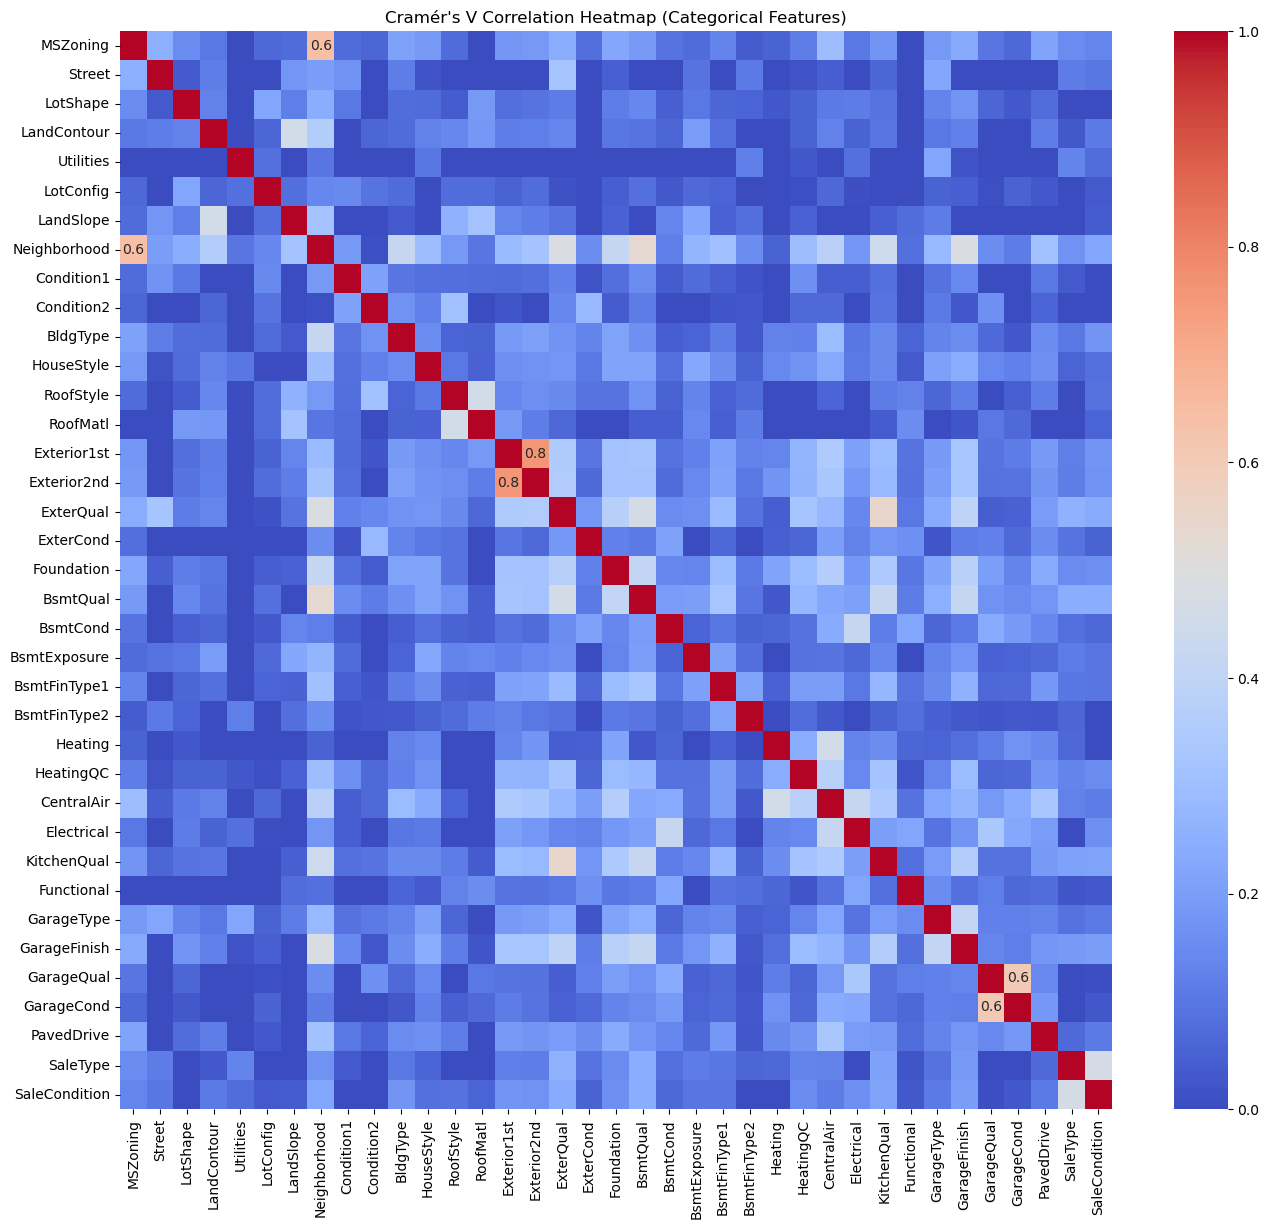

In [13]:
# cramer's v相关性阈值
# CRAMERS_V_THRESHOLD

# 1. 选取所有分类型特征
categorical_features = [col for col in df.columns if df[col].dtype == 'object']
# 2. 对所有分类型特征进行编码
df_encoded = df.copy()
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
# 3. 计算Cramér's V相关性矩阵
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # 修正phi2，避免过拟合
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))) if min((kcorr-1), (rcorr-1)) > 0 else np.nan

cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_features), len(categorical_features))),
                                index=categorical_features, columns=categorical_features)

for i, col1 in enumerate(categorical_features):
    for j, col2 in enumerate(categorical_features):
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        elif j < i:
            # 对称矩阵，直接赋值
            cramers_v_matrix.loc[col1, col2] = cramers_v_matrix.loc[col2, col1]
        else:
            v = cramers_v(df_encoded[col1], df_encoded[col2])
            cramers_v_matrix.loc[col1, col2] = v

# 新建变量，保存大于阈值的特征对的索引（不包括对角线和重复对）
redundant_features = []
for i, col1 in enumerate(categorical_features):
    for j, col2 in enumerate(categorical_features):
        if j > i:  # 只取上三角（不含对角线）
            v = cramers_v_matrix.loc[col1, col2]
            if v > CRAMERS_V_THRESHOLD and v < 1:
                redundant_features.append((col1, col2))
print('冗余特征对: \n', redundant_features)

# 可视化
annot_matrix = cramers_v_matrix.map(lambda x: f"{x:.1f}" if x > CRAMERS_V_THRESHOLD and x < 1 else "")
plt.figure(figsize=(16, 14))
sns.heatmap(cramers_v_matrix, annot=annot_matrix, fmt='', cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Correlation Heatmap (Categorical Features)")
plt.show()

- 删除大于阈值的冗余特征对中与SalePrice相关性较小的那个特征

In [14]:
# 删除冗余对中与SalePrice相关性较小的特征
features_to_remove = set()
for f1, f2 in redundant_features:
    # 计算f1和f2与SalePrice的Cramér's V相关性
    v1 = cramers_v(df_encoded[f1], df_encoded['SalePrice']) if 'SalePrice' in df_encoded.columns else 0
    v2 = cramers_v(df_encoded[f2], df_encoded['SalePrice']) if 'SalePrice' in df_encoded.columns else 0
    # 删除相关性较小的特征
    if v1 < v2:
        features_to_remove.add(f1)
    else:
        features_to_remove.add(f2)

df_encoded = df_encoded.drop(columns=list(features_to_remove))
categorical_features = [f for f in categorical_features if f not in features_to_remove]
print("已删除的冗余特征：", features_to_remove)

已删除的冗余特征： {'GarageCond', 'Exterior2nd', 'Neighborhood'}


3.2. 数值型特征通过皮尔逊相关系数测量线性相关程度，将绝对值大于等于阈值的特征视作冗余特征对
- 皮尔逊相线性相关性分析并可视化

冗余数值特征对: 
 [('GrLivArea', 'TotRmsAbvGrd'), ('TotalBsmtSF', '1stFlrSF'), ('GarageCars', 'GarageArea')]


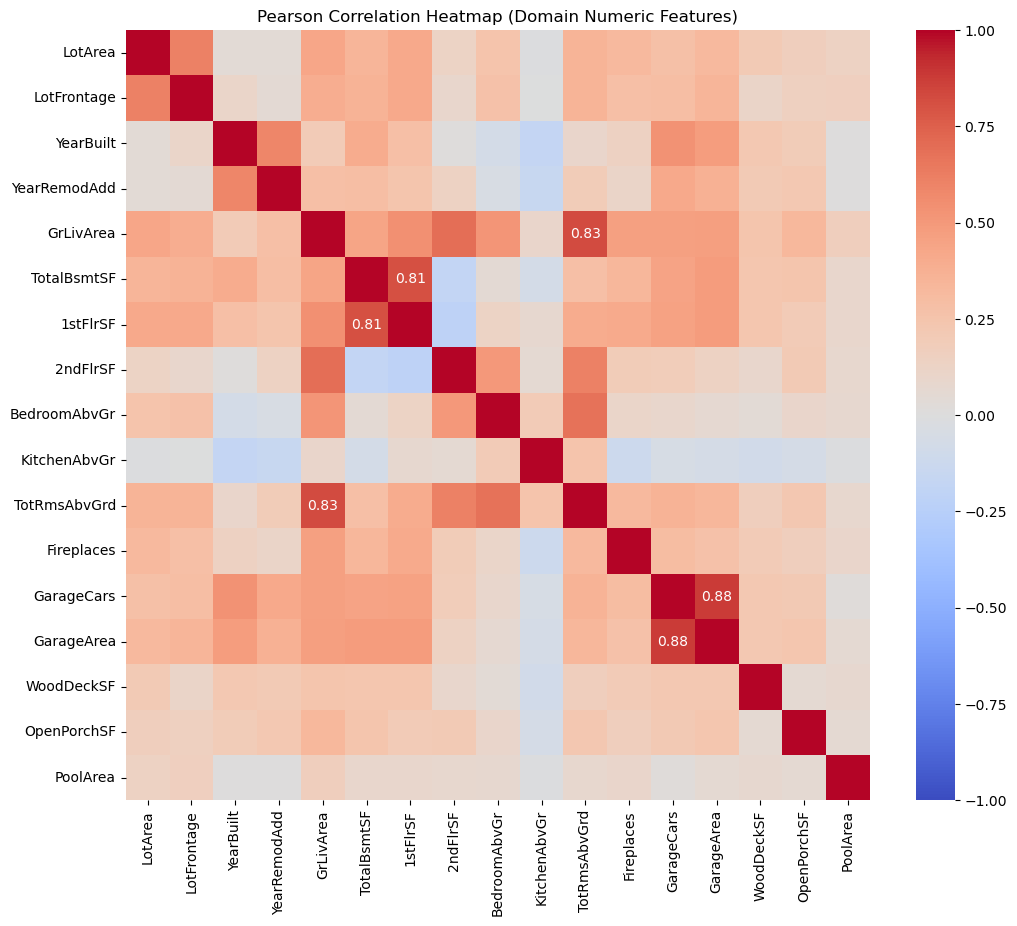

In [15]:
# 皮尔逊相关系数阈值
# PEARSON_THRESHOLD

# 选取 domain_rules 中的 key 且为数值型的特征
domain_numeric_features = []
for f in domain_rules.keys():
    if f in df_encoded.columns and df_encoded[f].dtype in ['int64', 'float64']:
        domain_numeric_features.append(f)
# 排除目标变量（SalePrice）
if 'SalePrice' in domain_numeric_features:
    domain_numeric_features.remove('SalePrice')
# 计算皮尔逊相关系数矩阵
pearson_corr_matrix = df_encoded[domain_numeric_features].corr(method='pearson')

# 新建变量，保存大于阈值的特征对的索引（不包括对角线和重复对）
redundant_features_num = []
for i, col1 in enumerate(domain_numeric_features):
    for j, col2 in enumerate(domain_numeric_features):
        if j > i:  # 只取上三角（不含对角线）
            corr = pearson_corr_matrix.loc[col1, col2]
            if abs(corr) >= PEARSON_THRESHOLD and abs(corr) < 1:
                redundant_features_num.append((col1, col2))
print('冗余数值特征对: \n', redundant_features_num)

# 可视化
annot_matrix_num = pearson_corr_matrix.map(lambda x: f"{x:.2f}" if abs(x) >= PEARSON_THRESHOLD and abs(x) < 1 else "")
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr_matrix, annot=annot_matrix_num, fmt='', cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Pearson Correlation Heatmap (Domain Numeric Features)")
plt.show()

- 删除绝对值大于阈值的冗余特征对中与SalePrice相关性较小的那个特征

In [16]:
# 对于冗余特征对，删除与SalePrice相关性较小的那个特征
features_to_remove_num = set()
# 计算每个特征与SalePrice的相关性
saleprice_corr = df_encoded[domain_numeric_features + ['SalePrice']].corr()['SalePrice'].abs()

for f1, f2 in redundant_features_num:
    # 比较f1和f2与SalePrice的相关性，删除相关性较小的
    if saleprice_corr[f1] < saleprice_corr[f2]:
        features_to_remove_num.add(f1)
    else:
        features_to_remove_num.add(f2)
df_encoded = df_encoded.drop(columns=list(features_to_remove_num))
domain_numeric_features = [f for f in domain_numeric_features if f not in features_to_remove_num]

print("已删除的冗余数值特征：", features_to_remove_num)

print("-------------------------------------")
print("删除冗余特征前的形状：", df.shape)
print("删除冗余特征后的形状：", df_encoded.shape)

已删除的冗余数值特征： {'1stFlrSF', 'GarageArea', 'TotRmsAbvGrd'}
-------------------------------------
删除冗余特征前的形状： (1460, 75)
删除冗余特征后的形状： (1460, 69)


# 4. 对 SalePrice 属性进行标准化与离散化

4.1. 对 SalePrice 属性进行标准化

In [17]:
scaler = StandardScaler()
# 将标准化结果存入新的列
df_encoded['SalePrice_std'] = scaler.fit_transform(df_encoded[['SalePrice']])
df_encoded['SalePrice_std'].head()

0    0.347273
1    0.007288
2    0.536154
3   -0.515281
4    0.869843
Name: SalePrice_std, dtype: float64

4.2. 根据 SalePrice 进行等宽离散化与等频离散化

等宽离散化的价格分界线： [34180, 178920, 322940, 466960, 610980, 755000]
等宽离散化后的前5项(id, index)：
0    1
1    1
2    1
3    0
4    1
Name: SalePrice_bin_width, dtype: int64
------------------------------
等频离散化的价格分界线： [34900, 124000, 147000, 179280, 230000, 755000]
等频离散化后的前5项(id, index)：
0    3
1    3
2    3
3    1
4    4
Name: SalePrice_bin_freq, dtype: int64


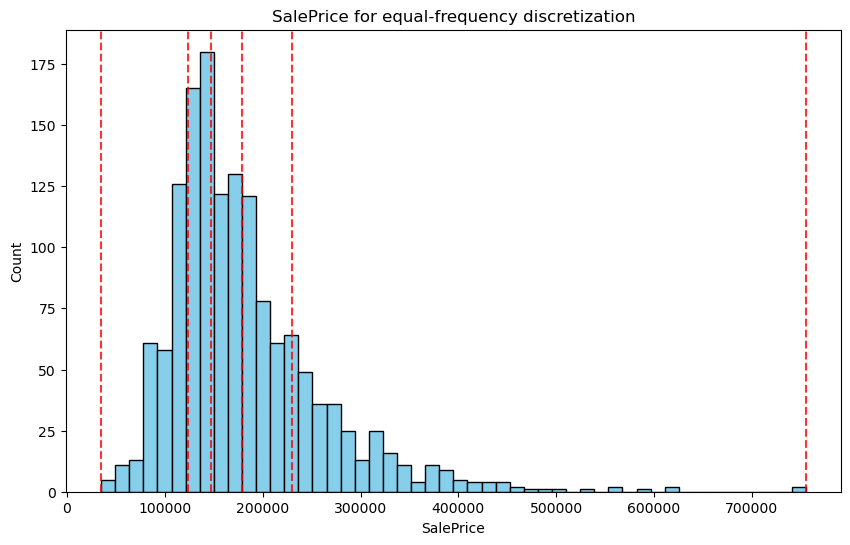

In [18]:
# N_BINS_WIDTH # 等宽分箱数
# N_BINS_FREQ # 等频分箱数

# 等宽离散化
saleprice_bin_width = pd.cut(df_encoded['SalePrice'], bins=N_BINS_WIDTH, labels=False, retbins=True)
df_encoded['SalePrice_bin_width'] = saleprice_bin_width[0]

# 等频离散化
saleprice_bin_freq = pd.qcut(df_encoded['SalePrice'], q=N_BINS_FREQ, labels=False, retbins=True, duplicates='drop')
df_encoded['SalePrice_bin_freq'] = saleprice_bin_freq[0]
freq_bins = saleprice_bin_freq[1]

print("等宽离散化的价格分界线：", [int(round(x)) for x in saleprice_bin_width[1]])
print("等宽离散化后的前5项(id, index)：")
print(df_encoded['SalePrice_bin_width'].head())
print("------------------------------")
print("等频离散化的价格分界线：", list(map(round, freq_bins.astype(int))))
print("等频离散化后的前5项(id, index)：")
print(df_encoded['SalePrice_bin_freq'].head())

# 可视化
plt.figure(figsize=(10, 6))
plt.hist(df_encoded['SalePrice'], bins=50, color='skyblue', edgecolor='black')
plt.title('SalePrice for equal-frequency discretization')
plt.xlabel('SalePrice')
plt.ylabel('Count')
for b in freq_bins:
    plt.axvline(b, color='red', linestyle='--', alpha=0.8)
plt.show()

# 5. 与房价SalePrice相关性最高的三个特征

In [19]:
num_features = [col for col in domain_rules.keys() if col not in features_to_remove_num]

# 皮尔逊相关系数计算与SalePrice的相关性
correlations = df_encoded[num_features + ['SalePrice']].corr(method='pearson')['SalePrice'].drop('SalePrice')
top3_features = correlations.sort_values(ascending=False).head(3)
print("与SalePrice相关性最高的三个特征：")
print(top3_features)

与SalePrice相关性最高的三个特征：
GrLivArea      0.708624
GarageCars     0.640409
TotalBsmtSF    0.633785
Name: SalePrice, dtype: float64
